# Online EdX experiment evaluation
A/B experiment was conducted on [CaltechDelftX: QuCryptox Quantum cryptography](https://courses.edx.org/courses/course-v1:CaltechDelftX+QuCryptox+3T2016) MOOC course offered by **Caltech University** and **TU Delft** at **EdX platform**. In this document, we are evaluating our proposed **question routing (recommendation of new questions) framework**. Users were split into three groups:

1. Question recommendation with educational-context group
2. Question recommendation without educational-context group
3. Control group without question recommendation


Course lasted 11 weeks from 3.10.2016 to 20.12.2016.

Online experiment started 14.11.2016 (start of week \#6). 

Welcome category is not considered (category_id = 2).

In [50]:
# imports
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display
import scipy.stats as stats

# graphics setup
%matplotlib inline
sns.set(color_codes=True)

# set up connection to the database
connection = pg.connect(database="askalot_edx_development", user="postgres", port=5432, 
                        host="localhost", password="")

## A/B groups statistics

### Users in groups are distributed evenly 

In [51]:
users = psql.read_sql("SELECT g.id, g.value, COUNT(*) FROM ab_groupings ab "+
                      "JOIN ab_groups g ON g.id=ab.ab_group_id GROUP BY g.id ORDER BY g.id", connection)
users

,id,value,count
0,1,Question routing full,1304
1,2,Question routing baseline,1305
2,3,Control group for question routing,1306


Users who signed up for the course during online experiment did not get a recommendation (control group) and they are not part of the analysis.

### Question routing recommended 118 questions during online experiment
Each question was recommended to both 10 most suitable users from educational-context group and to 10 most suitable users from group without educational context. 

In [52]:
answers_count = psql.read_sql("""
                                SELECT g.value, COUNT(DISTINCT(n.resource_id)) AS "Total number of recommended questions" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
                                GROUP BY g.id
                              """, connection)
display(answers_count)
rec_count = psql.read_sql("""
                                SELECT g.id, g.value, COUNT(DISTINCT(n.id)) AS "Total number of generated recommendations" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
                                GROUP BY g.id
                              """, connection)
rec_count

,value,Total number of recommended questions
0,Question routing full,118
1,Question routing baseline,118


,id,value,Total number of generated recommendations
0,1,Question routing full,1163
1,2,Question routing baseline,1173


### Recommendation click-through rate was more than 20%
Recommendation was send to users by both notifications in Askalot CQA system and recommended list of questions  were shown on their dashboard. 

Click-through rate is computed as portion of read recommendations to total number of recommendations.

,Absolute count,Unique users,Total CTR
0,491,73,0.208051


,value,Unique users,portion
0,Question routing full,37,0.111441
1,Question routing baseline,33,0.088983


,From dashboard,Absolute count,Unique users,Portion of CTR
0,False,433,61,0.881874
1,True,58,23,0.118126


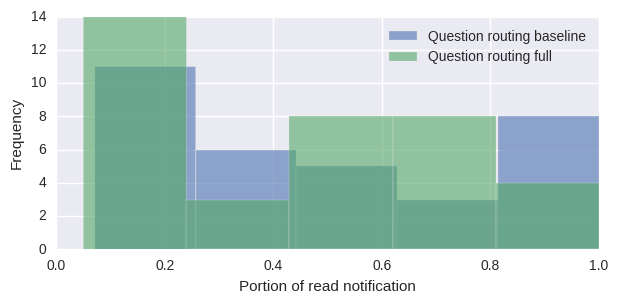

In [53]:
ctr = psql.read_sql("""   
    SELECT COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as "Total CTR"
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    """,connection)
display(ctr)

ctr_by_groups = psql.read_sql("""
    SELECT g.value, COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as portion
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    GROUP BY g.id ORDER BY g.id
    """, connection)
display(ctr_by_groups)

ctr_from_dashboard = psql.read_sql("""   
    SELECT n.from_dashboard AS "From dashboard", COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND unread=FALSE AND created_at < '2016-12-20') as "Portion of CTR" 
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE  AND n.created_at < '2016-12-20' GROUP BY n.from_dashboard """,connection)
display(ctr_from_dashboard)

ctr_by_users = psql.read_sql("""
    SELECT g.value, n.recipient_id, COUNT(n.id)::float / (SELECT COUNT(*) FROM notifications x WHERE x.action= 'recommendation' AND n.recipient_id=x.recipient_id) AS "portion"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    GROUP BY g.id, n.recipient_id ORDER BY g.id, COUNT(n.id) DESC
    """, connection)
plt.figure(figsize=(7,3))
ctr_by_users.groupby('value')['portion'].plot.hist(alpha=0.6, bins=5, legend=True)
plt.xlabel('Portion of read notification')

Group with educational context has better CTR by 2.2% and it has 3 more users who read any recommendation. From the histogram above, it is possible to see that baseline group has more users who read all the notifications or only a few.

Notifications were 7 times more efficient for sending a recommendation than list of questions at the dasboard.

### Question routing with educational-context has better recommendation success rate
Recommendations which were answered or commented by the recipient of the recommendation.

In [54]:
success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, a.author_id, a.text, a.created_at
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN answers a ON n.recipient_id = a.author_id AND q.id=a.question_id 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    UNION ALL
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, c.author_id, c.text, c.created_at
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN comments c ON (n.recipient_id = c.author_id AND q.id=c.commentable_id AND c.commentable_type = 'Shared::Question') 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    """,connection)

success_rec = success_rec.groupby('ab_group_id')['n_id'].count().to_frame(name = 'success_count').reset_index()
success_rec = pd.merge(success_rec, rec_count, left_on='ab_group_id', right_on="id", how='inner')
success_rec['success_portion'] = success_rec['success_count'] / success_rec['Total number of generated recommendations']
success_rec[['value', 'success_count', 'Total number of generated recommendations', 'success_portion']]

,value,success_count,Total number of generated recommendations,success_portion
0,Question routing full,22,1163,0.018917
1,Question routing baseline,5,1173,0.004263


### Questions count

In [55]:
questions_end = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'", connection)
questions_start = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at < '2016-11-14'", connection)

print("Questions before online experiment: %d" % questions_start.shape[0])
print("Questions during online experiment: %d" % questions_end.shape[0])

Questions before online experiment: 241
Questions during online experiment: 114


Note: Deletion of some questions by users cause the difference between recommended questions and total number of questions during online experiment.  

### Answers count

In [56]:
answers_end = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20'", connection)
answers_start = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14'", connection)
# professor - AND a.author_id != 4

print("Answers before online experiment: %d" % answers_start.shape[0])
print("Answers during online experiment: %d" % answers_end.shape[0])

Answers before online experiment: 250
Answers during online experiment: 129


### Comments count

In [57]:
comments_end = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20'", connection)
comments_start = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at < '2016-11-14'", connection)

print("Coments before online experiment: %d" % comments_start.shape[0])
print("Comments during online experiment: %d" % comments_end.shape[0])

Coments before online experiment: 383
Comments during online experiment: 164


## Course interaction

In [70]:
interaction_end = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at >= '2016-11-14' AND l.created_at < '2016-12-20'", connection)
interaction_start = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at < '2016-11-14'", connection)

print("Course interaction before online experiment: %d" % interaction_start.shape[0])
print("Course interaction during online experiment: %d" % interaction_end.shape[0])

print("Unique users interacting with a course before online experiment: %d" % interaction_start['lister_id'].nunique())
print("Unique users interacting with a course during online experiment: %d" % interaction_end['lister_id'].nunique())

Course interaction before online experiment: 55540
Course interaction during online experiment: 54074
Unique users interacting with a course before online experiment: 2436
Unique users interacting with a course during online experiment: 850


### Groups with question recommendation had more question views than control group 

Question views before online experiment: 10995
Question views during online experiment: 6861


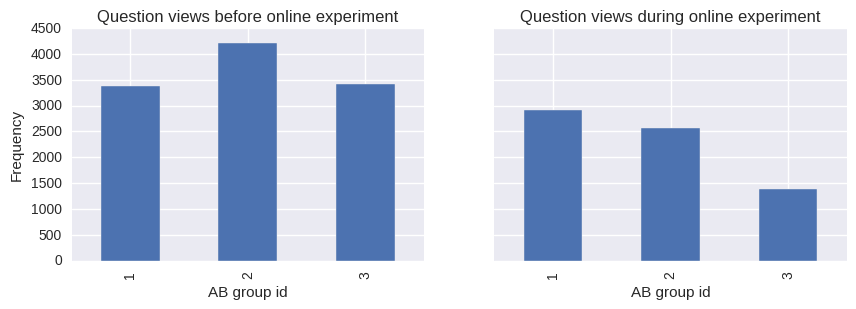

In [59]:
# read questions and filter columns
views_end = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "WHERE v.created_at >= '2016-11-14' AND v.created_at < '2016-12-20'", connection)
views_start = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "WHERE v.created_at < '2016-11-14'", connection)

print("Question views before online experiment: %d" % views_start.shape[0])
print("Question views during online experiment: %d" % views_end.shape[0])


# Histogram views before
views_by_groups = views_start.groupby('ab_group_id')["viewer_id"].count()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
views_by_groups.plot(kind="bar", title="Question views before online experiment", ax = ax1)
ax1.set(xlabel='AB group id', ylabel='Frequency')

# Histogram views during
views_by_groups = views_end.groupby('ab_group_id')["viewer_id"].count()

views_by_groups.plot(kind="bar", title="Question views during online experiment", ax=ax2)
ax2.set(xlabel='AB group id', ylabel='Frequency')

### Unique users with answers and comments
Comparing contributing users (answering, commenting) before the online experiment and during the online experiment?

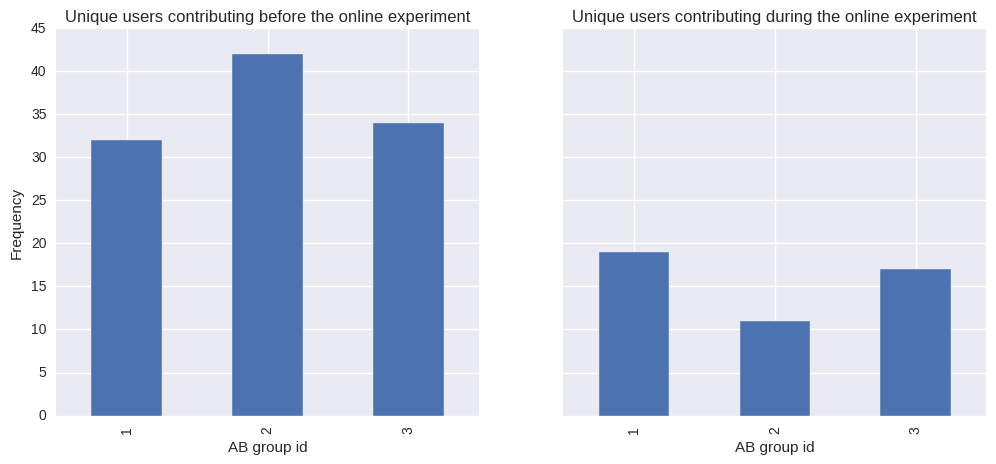

In [60]:
users_start = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    WHERE a.created_at < '2016-11-14')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at < '2016-11-14')
    ) as a
    """, connection)

users_during = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20')
    ) as a
    """, connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
users_start.groupby('ab_group_id')["author_id"].count().plot(kind="bar", ax=ax1, title="Unique users contributing before the online experiment")
ax1.set(xlabel='AB group id', ylabel='Frequency')
users_during.groupby('ab_group_id')["author_id"].count().plot(kind="bar", ax=ax2, title="Unique users contributing during the online experiment")
ax2.set(xlabel='AB group id', ylabel='Frequency')

In [61]:
# Create before and during dataframe with answer, question and comments counts

# Before
# questions
question_by_groups = questions_start.groupby('ab_group_id')["author_id"].count()
start_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_start.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_start.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Interactions
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
contributing_users_by_groups = users_start.groupby('ab_group_id')["author_id"].nunique()
temp = contributing_users_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')


print("Statistics for groups before online experiment")
display(start_df)

# During
# questions
question_by_groups = questions_end.groupby('ab_group_id')["author_id"].count()
end_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_end.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_end.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# interactions
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
interactions_by_groups = users_during.groupby('ab_group_id')["author_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')

print("Statistics for groups during online experiment")
display(end_df)

Statistics for groups before online experiment


,ab_group_id,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_contributing
0,1,88,97,131,19178,814,32
1,2,84,75,125,18752,811,42
2,3,69,78,127,17610,811,34


Statistics for groups during online experiment


,ab_group_id,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_contributing
0,1,45,79,94,29909,282,19
1,2,47,6,45,11311,267,11
2,3,22,44,25,12854,301,17


Users interacting with the course decreased during the online course. The course got harder and it is typical pattern present in the MOOC courses.

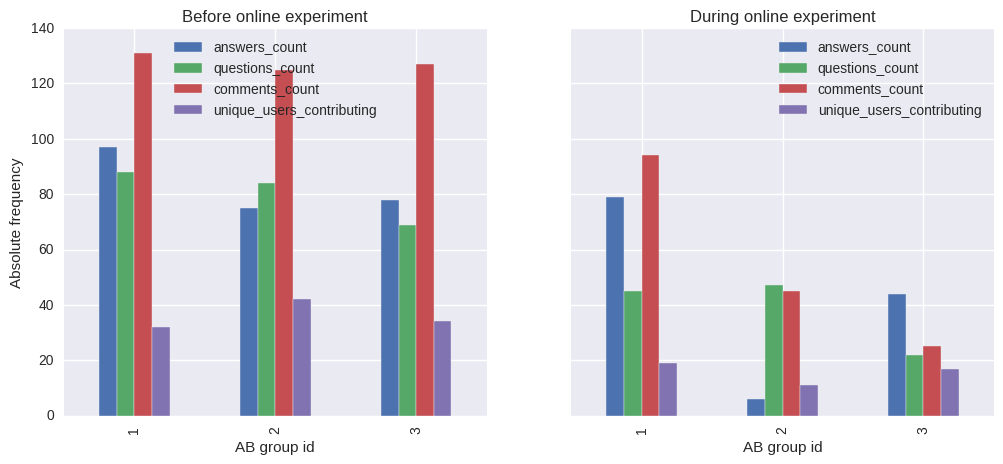

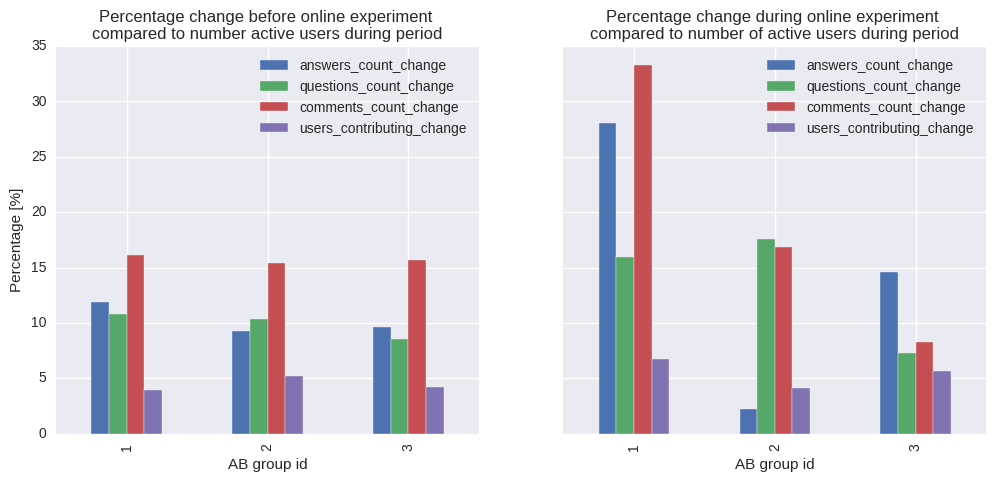

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
start_df.groupby('ab_group_id')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax1, kind="bar", title="Before online experiment")
ax1.set(xlabel='AB group id', ylabel='Absolute frequency')

end_df.groupby('ab_group_id')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax2, kind="bar", title="During online experiment")
ax2.set(xlabel='AB group id', ylabel='Absolute frequency')

# Normalization by number of active users
start_df['questions_count_change']= start_df['questions_count']*100 / start_df['unique_users_interacting']
start_df['answers_count_change']= start_df['answers_count']*100 / start_df['unique_users_interacting']
start_df['comments_count_change']= start_df['comments_count']*100 / start_df['unique_users_interacting']
start_df['users_contributing_change']= start_df['unique_users_contributing']*100 / start_df['unique_users_interacting']
end_df['questions_count_change']= end_df['questions_count']*100 / end_df['unique_users_interacting']
end_df['answers_count_change']= end_df['answers_count']*100 / end_df['unique_users_interacting']
end_df['comments_count_change']= end_df['comments_count']*100 / end_df['unique_users_interacting']
end_df['users_contributing_change']= end_df['unique_users_contributing']*100 / end_df['unique_users_interacting']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
start_df.groupby('ab_group_id')["answers_count_change", "questions_count_change", "comments_count_change", "users_contributing_change"].sum()\
    .plot(kind="bar", title="Percentage change before online experiment \ncompared to number active users during period", ax=ax1)
ax1.set(xlabel='AB group id', ylabel='Percentage [%]')

end_df.groupby('ab_group_id')["answers_count_change", "questions_count_change", "comments_count_change", "users_contributing_change"].sum()\
    .plot(kind="bar", title="Percentage change during online experiment \ncompared to number of active users during period", ax=ax2)
ax2.set(xlabel='AB group id', ylabel='Percentage [%]')

### Question recommendation lowered instructors load by 5%

In [63]:
prof_answers_before = psql.read_sql("SELECT COUNT(a.author_id) FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "
                    "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14' AND a.author_id = 4", connection)
print("Professor answers before online experiment: %d" % prof_answers_before['count'])

TAs = psql.read_sql("""SELECT DISTINCT(user_id) FROM assignments""",connection)

contributions = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.created_at FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    UNION ALL
    SELECT c.author_id, ab.ab_group_id, c.created_at FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    """, connection)

total_end_contributions = answers_end.shape[0] + comments_end.shape[0]
total_before_contributions = answers_start.shape[0] + comments_start.shape[0]


contributions_before = contributions[(contributions['created_at'] < '2016-11-14')]
print("Teaching assistants contributing %.2f%% of all contributions before online experiment." % (contributions_before['author_id'].isin(TAs['user_id']).sum()*100 / float(total_before_contributions)))

contributions_end = contributions[(contributions['created_at'] >= '2016-11-14') & (contributions['created_at'] < '2016-12-20')]
print("Teaching assistants contributing %.2f%% of all contributions during online experiment." % (contributions_end['author_id'].isin(TAs['user_id']).sum()*100 / float(total_end_contributions)))
#contributions_end[~contributions_end['author_id'].isin(TAs['user_id'])]['author_id'].count()

Professor answers before online experiment: 45
Teaching assistants contributing 34.60% of all contributions before online experiment.
Teaching assistants contributing 31.74% of all contributions during online experiment.


Note: Professor is part of group 1 and he had 45 answers before online experiment (nearly half of answers for group 1), which caused not equal distribution of answers count when splitting users to the groups.  

## Proposed question routing framework has covered 48% of active CQA users. 
Recommendation coverage - how many unique users did get the recommendation? 

Active users are users who have seen at least one question in CQA system.

In [64]:
users_coverage = psql.read_sql("""
    WITH active_users AS (
      SELECT COUNT(*) from users u JOIN ab_groupings ab ON u.id = ab.user_id 
      WHERE u.views_count > 0 AND ab.ab_group_id != 3
    )
    SELECT ab.ab_group_id, COUNT(DISTINCT(ab.user_id)) AS total_recommended_to_users, (SELECT * FROM active_users) AS total_active_users, 
    COUNT(DISTINCT(ab.user_id)) / (SELECT * FROM active_users)::float AS user_coverage FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
    GROUP BY ab.ab_group_id
    """, connection)
display(users_coverage)
print("Total user coverage: %f" % users_coverage['user_coverage'].sum())

,ab_group_id,total_recommended_to_users,total_active_users,user_coverage
0,1,134,544,0.246324
1,2,130,544,0.238971


Total user coverage: 0.485294


## Question recommendation increased question answering success rate
Question answering success rate is number of questions with at least one answer.

Note: Hello topics are removed as an answer is not expected to them. Only questions are considered, not discussions and bug reports.

In [65]:
questions_before = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14' AND question_type_id = 1 
            GROUP BY q.id
            """,connection)

questions_during = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' 
                                    AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20' AND question_type_id = 1 
            GROUP BY q.id
            """,connection)
before_success_rate = (questions_before['answers_count'] != 0).sum()*100 / float(len(questions_before))
during_success_rate = (questions_during['answers_count'] != 0).sum()*100 / float(len(questions_during))

print("Success rate before online experiment: %.3f %%" % before_success_rate)
print("Success rate during online experiment: %.3f %%" % during_success_rate)

Success rate before online experiment: 77.632 %
Success rate during online experiment: 79.452 %


### Average answer quality decreased with a recommendation.
Quality of answers is estimated by number of earned votes for a particular answer.

In [66]:
quality = psql.read_sql("""
            SELECT (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at < '2016-11-14') as quality_before, 
            (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20') as quality_during
          """, connection)
quality

,quality_before,quality_during
0,0.521236,0.40146


### Average time to answer increased with a recommendation

In [67]:
before_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14'
            GROUP BY q.id
            """,connection)

during_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
            GROUP BY q.id
            """,connection)

print("Average time to answer before online experiment")
avg_time_before = (before_answers_time['first_answer_time'] - before_answers_time['created_at']).sum() / len(before_answers_time) 
print(avg_time_before)

print("Average time to answer during online experiment")
avg_time_during = (during_answers_time['first_answer_time'] - during_answers_time['created_at']).sum() / len(during_answers_time)
print(avg_time_during)

print("Average time to answer incresed with question recommendation by:")
print(avg_time_during - avg_time_before)

Average time to answer before online experiment
1 days 00:25:24.515813
Average time to answer during online experiment
1 days 16:00:44.794221
Average time to answer incresed with question recommendation by:
0 days 15:35:20.278407


### Contributing users for each week compared to active users in a week did not change
Contribution is defined as asking, answering and commenting. Active user is a user who saw any question during a particular week.

In [73]:
contributing_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Contributing users"
    FROM activities a
    WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment')
    AND a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
active_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Active users" 
    FROM activities a
    WHERE a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
users = pd.merge(contributing_users, active_users, on='weekly', how='inner')
users['Contributing to active portion'] = users['Contributing users']*100 / users['Active users']
display(users.ix[1:5])
display(users.ix[6:])

print("Recommendation effect size: %.3f" % (users.ix[6:]['Contributing to active portion'].mean() - users.ix[1:5]['Contributing to active portion'].mean()))

,weekly,Contributing users,Active users,Contributing to active portion
1,2016-10-10 00:00:00+02:00,48,1661,2.889825
2,2016-10-17 00:00:00+02:00,52,919,5.658324
3,2016-10-24 00:00:00+02:00,36,730,4.931507
4,2016-10-31 00:00:00+01:00,26,614,4.234528
5,2016-11-07 00:00:00+01:00,21,513,4.093567


,weekly,Contributing users,Active users,Contributing to active portion
6,2016-11-14 00:00:00+01:00,23,535,4.299065
7,2016-11-21 00:00:00+01:00,27,478,5.648536
8,2016-11-28 00:00:00+01:00,23,617,3.727715
9,2016-12-05 00:00:00+01:00,21,463,4.535637
10,2016-12-12 00:00:00+01:00,31,545,5.688073


Recommendation effect size: 0.418


## Anova

In [74]:
df = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.votes_difference, (a.created_at - q.created_at) as "time to answer" FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id 
    WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
    """, connection)
df['time to answer'] = df['time to answer'].astype('timedelta64[m]')

full_rec_group = df[df['ab_group_id'] == 1].copy().reset_index()
baseline_rec_group = df[df['ab_group_id'] == 2].copy().reset_index()
control_group = df[df['ab_group_id'] == 3].copy().reset_index()

print("Votes difference: \t\tEducational %.3f \tBaseline %.3f \t\tControl %.3f" % (full_rec_group['votes_difference'].mean(), baseline_rec_group['votes_difference'].mean(), control_group['votes_difference'].mean()))
print("Time to answer difference: \tEducational %.3f \tBaseline %.3f \t\tControl %.3f" % (full_rec_group['time to answer'].mean(), baseline_rec_group['time to answer'].mean(), control_group['time to answer'].mean()))

display(stats.ttest_ind(full_rec_group['votes_difference'], baseline_rec_group['votes_difference']))
stats.ttest_ind(full_rec_group['time to answer'], baseline_rec_group['time to answer'])
#stats.f_oneway(full_rec_group, baseline_rec_group, control_group)

Votes difference: 		Educational 0.461 	Baseline 0.800 		Control 0.341
Time to answer difference: 	Educational 3957.645 	Baseline 1587.400 		Control 4889.244


Ttest_indResult(statistic=-0.79438988801703714, pvalue=0.42934843075895845)

Ttest_indResult(statistic=0.77353755058492357, pvalue=0.44151288804296052)